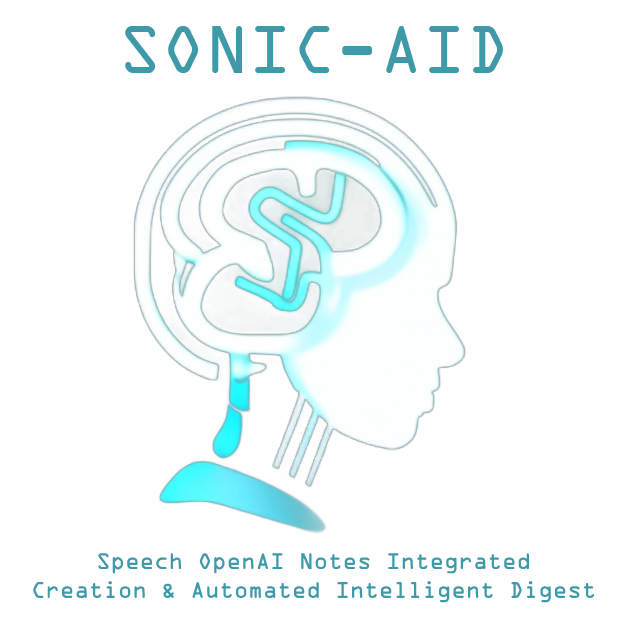

SONIC-AID property of Mika Martin (22938292). You can find a guide in this link: ___

> Please only use this software in tandem with notes/ lecture content you have rights to.

V4.0 Has the added feature of being able to use PDF's instead of audio/video files.

---

In [ ]:
#@title Setup (This may take 5-10 minutes - this is normal)
!pip install -q pipx
!pip install -q pytube
!apt-get install -qq python3.10-venv > /dev/null
!pipx install insanely-fast-whisper
!pipx ensurepath
!pip install PyMuPDF
!pip install -q openai
!pip install -q langchain
!pip install -q tiktoken

In [ ]:
#@title Video Selection
import os
os.environ['PATH'] += ":/root/.local/bin"
from google.colab import files, drive
from pytube import YouTube
import requests
import subprocess
import json
import fitz

language_codes = {
    "english": "en",
    "japanese": "ja",
    "chinese": "zh",
    "korean": "ko",
    "indian": "hi",  # Assuming Hindi for Indian; adjust if necessary
    "indonesian": "id"
}

language = "english" #@param ["english", "japanese", "chinese", "korean", "indian", "indonesian"]

def process_audio(audio_path):
    # Define the output text file name
    output_text_file = '/content/output.txt'
    cleaned_output_file = '/content/cleaned_output.txt'

    selected_language_code = language_codes[language.lower()]

    command = [
        '/root/.local/bin/insanely-fast-whisper',
        '--file-name', audio_path,
        '--transcript-path', output_text_file,
        '--language', selected_language_code
    ]

    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode != 0:
        print("Command failed to execute:", result.stderr)
        return "Error in processing audio file."

    # Function to clean and save the cleaned transcript
    def clean_and_save_transcript():
        try:
            # Read the content of the output text file
            with open(output_text_file, 'r') as file:
                data = json.load(file)
        except Exception as e:
            print(f"Failed to read or parse the output text file: {e}")
            return "Error reading transcription result."

        # Extract and join all text, ignoring timestamps
        cleaned_text = ' '.join(chunk['text'] for chunk in data['chunks'])

        # Save the cleaned text to a new file
        try:
            with open(cleaned_output_file, 'w') as file:
                file.write(cleaned_text)
        except Exception as e:
            print(f"Failed to save the cleaned transcript: {e}")
            return "Error saving cleaned transcription."

        return cleaned_text

    # Clean and save the transcript, and return the cleaned transcribed text
    return clean_and_save_transcript()

    # Clean and save the transcript
    clean_and_save_transcript()

    # Read and return the cleaned transcribed text
    with open(cleaned_output_file, 'r') as file:
        cleaned_text = file.read()
    return cleaned_text

# Function to check if a link is a video or audio file
def is_video_or_audio_link(link):
    response = requests.head(link)
    content_type = response.headers.get('content-type')
    if content_type:
        main_type, sub_type = content_type.split('/')
        return main_type == 'video' or main_type == 'audio'
    return False

# Function to download the file from a given link
def download_file(link):
    response = requests.get(link)
    filename = link.split('/')[-1]
    with open(filename, 'wb') as file:
        file.write(response.content)
    return filename

def clear_directory_of_images(directory):
    for item in os.listdir(directory):
        if item.endswith(('.png', '.jpg', '.jpeg', '.gif', '.webp')):
            os.remove(os.path.join(directory, item))

def convert_pdf_to_images(pdf_path):
    clear_directory_of_images('/content/')  # Clear the directory of images before processing new PDF
    doc = fitz.open(pdf_path)
    image_paths = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        pix = page.get_pixmap()
        image_path = f'/content/page_{page_num}.png'
        pix.save(image_path)
        image_paths.append(image_path)
    doc.close()
    return image_paths

# Function to handle file upload changes slightly to adapt to the new processing function
def handle_file_upload(file_upload):
    for file_name, file_contents in file_upload.items():
        file_ext = os.path.splitext(file_name)[1]
        with open(f'/content/audio{file_ext}', 'wb') as file:
            file.write(file_contents)
        return process_audio(f"/content/audio{file_ext}")

def handle_file_upload(file_upload):
    for file_name, file_contents in file_upload.items():
        file_ext = os.path.splitext(file_name)[1].lower()
        with open(f'/content/{file_name}', 'wb') as file:
            file.write(file_contents)

        if file_ext == '.pdf':
            return convert_pdf_to_images(f"/content/{file_name}")
        else:
            return process_audio(f"/content/{file_name}")


def handle_youtube_link(youtube_link):
    try:
        yt = YouTube(youtube_link)
        # Select the highest resolution stream available that contains audio
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        if stream:
            # Download the video
            download_path = '/content/downloaded_video.mp4'
            stream.download(output_path='/content/', filename='downloaded_video.mp4')
            # Now process the audio from the downloaded video
            if os.path.exists(download_path):
                transcription_text = process_audio(download_path)
                return transcription_text
            else:
                return "Failed to download the video for processing."
        else:
            return "No suitable video stream found."
    except Exception as e:
        return f"An error occurred: {str(e)}"

options = "File" #@param ["Youtube", "File", "Weblink", "Google Drive"]

if options == "Youtube":
    youtube_link = input("Enter YouTube link: ")
    text = handle_youtube_link(youtube_link)
    print(text)

elif options == "File":
    file_upload = files.upload()
    for file_name, file_contents in file_upload.items():
        file_ext = os.path.splitext(file_name)[1].lower()  # Extract the file extension and convert to lower case
        with open(f'/content/{file_name}', 'wb') as file:
            file.write(file_contents)

        if file_ext == '.pdf':
            # If the file is a PDF, process it as a PDF
            image_paths = convert_pdf_to_images(f'/content/{file_name}')
            print("Converted images saved at:")
            for path in image_paths:
                print(path)
        else:
            # If the file is not a PDF, process it using the original function
            text = process_audio(f'/content/{file_name}')
            print(text)

elif options == "Weblink":
    weblink = input("Enter the web link: ")
    if is_video_or_audio_link(weblink):
        filename = download_file(weblink)
        text = process_audio(filename)
        print(text)
    else:
        print("The provided link is not a video or audio file.")

elif options == "Google Drive":
    drive.mount('/content/drive')
    file_path = input("Enter the Google Drive file path: ")
    file_ext = os.path.splitext(file_path)[1].lower()
    if os.path.isfile(file_path):
        if file_ext == '.pdf':
            # Handle PDF file
            image_paths = convert_pdf_to_images(file_path)
            print("Converted images saved at:")
            for path in image_paths:
                print(path)
        else:
            # Handle other file types as audio
            text = process_audio(file_path)
            print(text)
    else:
        print("The provided path does not point to a file.")

else:
    print("Invalid option selected.")




In [ ]:
#@title GPT Options
import base64
import openai
import time
import requests
import concurrent.futures
from os import listdir
from os.path import isfile, join

input_openai_api_key = '' # @param {type:"string"}
openai.api_key = input_openai_api_key

open('/content/cleaned_output.txt', 'a').close()

GPT_options = "Flashcards" #@param ["Summarize", "Flashcards", "Custom", "Transcript", "Flashcard from PDF"]

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def generate_flashcard(image_path):
    base64_image = encode_image(image_path)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Create flashcards for the following image in the format of Flashcard X: \n Q: Question \n A: Answer"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 500
    }

    attempts = 0
    max_attempts = 3  # Set maximum number of retries
    while attempts < max_attempts:
        try:
            # Attempt to post the request with a 15-second timeout
            response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload, timeout=15)
            if 'choices' in response.json():
                return response.json()['choices'][0]['message']['content']
            else:
                return f"Error processing image {image_path}: {response.json().get('error', response.json())}"
        except requests.exceptions.Timeout:
            attempts += 1
            print(f"Timeout occurred for {image_path}. Attempt {attempts} of {max_attempts}. Retrying...")
            if attempts == max_attempts:
                return f"Request timed out after {max_attempts} attempts for {image_path}"
        except requests.exceptions.RequestException as e:
            return f"Request failed for {image_path}: {str(e)}"


def process_images_from_pdf(directory):
    image_files = [f for f in listdir(directory) if isfile(join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.webp'))]
    text_file_path = '/content/flashcards_output.txt'

    if os.path.exists(text_file_path):
        os.remove(text_file_path)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_image = {executor.submit(generate_flashcard, join(directory, image_file)): image_file for image_file in image_files}
        with open(text_file_path, 'w') as text_file:
            for future in concurrent.futures.as_completed(future_to_image):
                image_path = future_to_image[future]
                try:
                    result = future.result()
                    text_file.write(result + '\n\n')
                except Exception as exc:
                    print(f'{image_path} generated an exception: {exc}')

    # Explicitly shutdown the executor
    executor.shutdown(wait=True)

    with open(text_file_path, 'r') as text_file:
        print(text_file.read())

# Function to read the cleaned transcript
def read_transcript(file_path='/content/cleaned_output.txt'):
    with open(file_path, 'r') as file:
        return file.read()

# Read the text from the cleaned output file
text = read_transcript()

# Now, split the text into chunks based on the selected GPT option
chunks = [text[i:i+10000] for i in range(0, len(text), 10000)] if GPT_options == "Summarize" else [text[i:i+1000] for i in range(0, len(text), 1000)]

# Initialize the OpenAI client
client = openai.OpenAI(api_key=openai_api_key)

def generate_flashcards(chunks):
    response = ""
    for i, chunk in enumerate(chunks, start=1):
        retry_count = 0
        while retry_count < 5:
            try:
                chatproc = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "system", "content": "You are a student taking notes, create csv flashcards Example:`Question, Answer` from the following"},{"role": "user", "content": chunk}]
                )
                chunk_response = chatproc.choices[0].message.content.strip()
                if "Question, Answer" in chunk_response or "Question,Answer" in chunk_response:
                    response += chunk_response
                    break
                else:
                    retry_count += 1
                    print(f"Chunk response did not contain 'Question, Answer' or 'Question,Answer'. Retrying after {(1 + retry_count) ** 2} seconds...")
                    time.sleep((1 + retry_count) ** 2)
            except openai.RateLimitError as e:
                retry_count += 1
                print(f"Exception caught: {type(e).__name__}")
                print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
                time.sleep((1 + retry_count) ** 2)
            except openai.APIConnectionError as e:
                retry_count += 1
                print(f"Connection exception caught: {type(e).__name__}")
                print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
                time.sleep((1 + retry_count) ** 2)
            except Exception as e:
                retry_count += 1
                print(f"Unknown exception caught: {type(e).__name__}")
                print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
                time.sleep((1 + retry_count) ** 2)
        else:
            print(f"Chunk response did not contain 'Question, Answer' or 'Question,Answer' after 5 retries. Moving on to next chunk.")
        print(f"Chunk {i} out of {len(chunks)} has been processed.")
    lines = response.split("\n")
    new_lines = []
    for line in lines:
        line = line.strip().replace("Question, Answer", "").replace("Question,Answer", "")
        new_lines.append(line)

    cleaned_text = "\n".join(new_lines)
    print(cleaned_text)

def generate_notes(chunks):
    final_sections = []
    for i, chunk in enumerate(chunks, start=1):
        retry_count = 0
        while retry_count < 5:
            try:
                # Request GPT-3 to summarize the chunk into bullet points.
                bullet_points_prompt = f"Summarize the following lecture transcript into bullet points:\n\n{chunk}"
                response = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "system", "content": bullet_points_prompt}]
                )
                bullet_points = response.choices[0].message.content.strip()

                # Now group those bullet points into sections.
                sections_prompt = "Group the following bullet points into coherent sections with headings:\n\n" + bullet_points
                response = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "system", "content": sections_prompt}]
                )
                sections_response = response.choices[0].message.content.strip()
                final_sections.append(sections_response)
                break
            except openai.RateLimitError as e:
                retry_count += 1
                print(f"Rate limit exception caught: {type(e).__name__}")
                print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
                time.sleep((1 + retry_count) ** 2)
            except Exception as e:
                retry_count += 1
                print(f"Unknown exception caught: {type(e).__name__}")
                print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
                time.sleep((1 + retry_count) ** 2)
        else:
            print(f"Failed to generate notes for chunk after 5 retries. Moving on to next chunk.")
        print(f"Chunk {i} out of {len(chunks)} has been processed.")
    return '\n\n'.join(final_sections)

def custom_gpt3_interaction(system_content, user_content):
    retry_count = 0
    while retry_count < 5:
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": system_content},
                    {"role": "user", "content": user_content}
                ]
            )
            return response.choices[0].message.content.strip()
        except openai.RateLimitError as e:
            retry_count += 1
            print(f"Rate limit exception caught: {type(e).__name__}")
            print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
            time.sleep((1 + retry_count) ** 2)
        except openai.APIConnectionError as e:
            retry_count += 1
            print(f"Connection exception caught: {type(e).__name__}")
            print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
            time.sleep((1 + retry_count) ** 2)
        except Exception as e:
            retry_count += 1
            print(f"Unknown exception caught: {type(e).__name__}")
            print(f"Retrying after {(1 + retry_count) ** 2} seconds...")
            time.sleep((1 + retry_count) ** 2)
    print("Failed to get a response after 5 retries. Please try again later.")
    return None


if GPT_options == "Flashcards":
    generate_flashcards(chunks)
elif GPT_options == "Summarize":
    notes = generate_notes(chunks)
    print(notes)
elif GPT_options == "Custom":
    custom_system_content = input("Please enter your system message: ")
    custom_user_content = input("Please enter your user message: ")
    response = custom_gpt3_interaction(custom_system_content(custom_user_content))  # Ensure custom_gpt3_interaction function is defined or provide implementation
    print(response)
elif GPT_options == "Transcript":
  print(text)
elif GPT_options == "Flashcard from PDF":
    process_images_from_pdf('/content/')
else:
    print("Invalid option selected.")


In [ ]:
#@title Flashcard Cleaning
def parse_flashcards(file_path):
    # Open the file for reading
    with open(file_path, 'r') as file:
        content = file.readlines()

    flashcards = {}
    question = None

    # Iterate through each line in the file
    for line in content:
        if line.startswith('Q:'):
            # Strip leading and trailing whitespaces and the newline character
            question = line.strip().replace('Q: ', '').replace('\n', '')
        elif line.startswith('A:'):
            answer = line.strip().replace('A: ', '').replace('\n', '')
            if question:
                # Store the question and answer in the dictionary
                flashcards[question] = answer
                question = None  # Reset question for the next pair

    # Formatting the output as "Question::Answer\n"
    output_format = ''
    for q, a in flashcards.items():
        output_format += f'{q}::{a}\n'

    return output_format

# Specify the path to your flashcard file
file_path = '/content/flashcards_output.txt'
formatted_flashcards = parse_flashcards(file_path)
print(formatted_flashcards)
